## Q1

In [12]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt


N = 1000  
num_hidden_units = 3  
samples = 30  

def teacher_network(epsion):
    B = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))
    y = np.dot(B, epsion)
    g_activatey = erf(y / np.sqrt(2))
    sigma = np.sum(g_activatey)
    return sigma
    
def average_sample(samples):
    results = []
    epsion = np.random.randn(N)
    
    for _ in range(samples):
        result = teacher_network(epsion)
        results.append(result)
    return np.mean(results)
    
output = average_sample(samples)
print(f"Average output of Teacher: {output}")

Average output of Teacher: 0.2138761967053542


## Q2

In [10]:
def compute_lap(B):
    lap = np.zeros((num_hidden_units, num_hidden_units)) 
    for n in range(num_hidden_units):
        for m in range(num_hidden_units):
            lap[n, m] = np.sum(B[n,:] * B[m,:]) 
    return lap

def compute_overlaps():
    ave_lap = np.zeros((num_hidden_units, num_hidden_units))  
    for _ in range(samples):
        B = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))
        lap = compute_lap(B)
        ave_lap += lap   

    ave_lap /= samples   

    print(f"Average output of T_nm from Teacher:\n{ave_lap}")

    kronecker_delta = np.eye(num_hidden_units)
    print("\nExpected Kronecker delta:\n", kronecker_delta)
    logicbool = np.allclose(ave_lap, kronecker_delta, atol=1e-1)
    print("\nT_nm close to Kronecker delta:", logicbool)

compute_overlaps()

Average output of T_nm from Teacher:
[[ 1.00208544 -0.00908787 -0.00616612]
 [-0.00908787  1.02038293  0.00660119]
 [-0.00616612  0.00660119  0.98559463]]

Expected Kronecker delta:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

T_nm close to Kronecker delta: True


## Q3

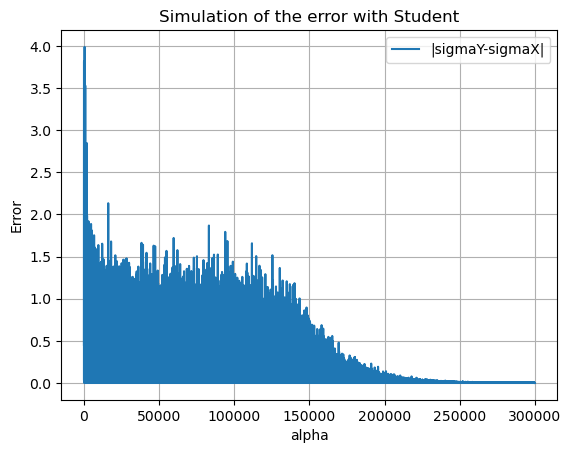

The J_weights:
[[ 0.01986414  0.01691202  0.04037859 ... -0.01883082  0.02497862
  -0.05310321]
 [ 0.04475495  0.00789412 -0.00147691 ... -0.02388425 -0.00645084
  -0.00609441]
 [-0.02085221  0.02008644  0.01260382 ... -0.02027507 -0.05725596
   0.06412222]]


In [17]:
import matplotlib.pyplot as plt

N = 1000 
num_hidden_units = 3  
alpha = 300  
eta = 1
rate = eta / N
dt = 1/N
steps = int(alpha / dt)

def g(x):
    return erf(x / np.sqrt(2))
    
def g_dot(x):
    return (np.sqrt(2) / np.sqrt(np.pi)) * np.exp(-x**2 / 2)

def teacher_output(B, epsion):
    y = np.dot(B, epsion)
    g_y = g(y)
    sigmay = np.sum(g_y)
    return sigmay, g_y, y

def student_output(J, epsion):
    x = np.dot(J, epsion)
    g_x = g(x)
    sigmax = np.sum(g_x)
    return sigmax, g_x, x
    
def online_learning():
    B = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))
    J = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))   
    errors = []
    
    for t in range(steps):
        epsion = np.random.normal(0, 1, N)
        sigma_y, g_y, y = teacher_output(B, epsion)
        sigma_x, g_x, x = student_output(J, epsion)        
        errors.append(abs(sigma_y - sigma_x))
        
        for n in range(num_hidden_units):
            g_dot_x = g_dot(x[n]) 
            delta = rate * g_dot_x * (sigma_y - sigma_x) * epsion
            J[n] += delta 
    plt.figure()
    plt.plot(errors,label = '|sigmaY-sigmaX|')
    plt.xlabel('alpha')
    plt.ylabel('Error')
    plt.title('Simulation of the error with Student')
    plt.grid()
    plt.legend()
    plt.show()
    return J
J  = online_learning()
print(f'The J_weights:\n{J}')

## Q4

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf

def generateQR():
    B = np.random.normal(0, 1 / np.sqrt(N), (num_hidden_units, N))
    J = np.random.normal(0, 1 / np.sqrt(N), (num_hidden_units, N))
    errors = []
    R_list = []
    Q_list = []
    for t in range(steps):
        epsion = np.random.normal(0, 1, N)
        sigma_y, g_y, y = teacher_output(B, epsion)
        sigma_x, g_x, x = student_output(J, epsion)
        errors.append(abs(sigma_y - sigma_x))

        for n in range(num_hidden_units):
            g_dot_x = g_dot(x[n]) 
            delta = rate * g_dot_x * (sigma_y - sigma_x) * epsion
            J[n] += delta        
        if (t+1) % 1000 == 0:
            R = np.dot(J, B.T) 
            Q = np.dot(B, B.T)
            R_list.append(R)
            Q_list.append(Q)

    R_list = np.array(R_list)   
    Q_list = np.array(Q_list)
    return Q_list, R_list

Q_list, R_list = generateQR()

## Q5

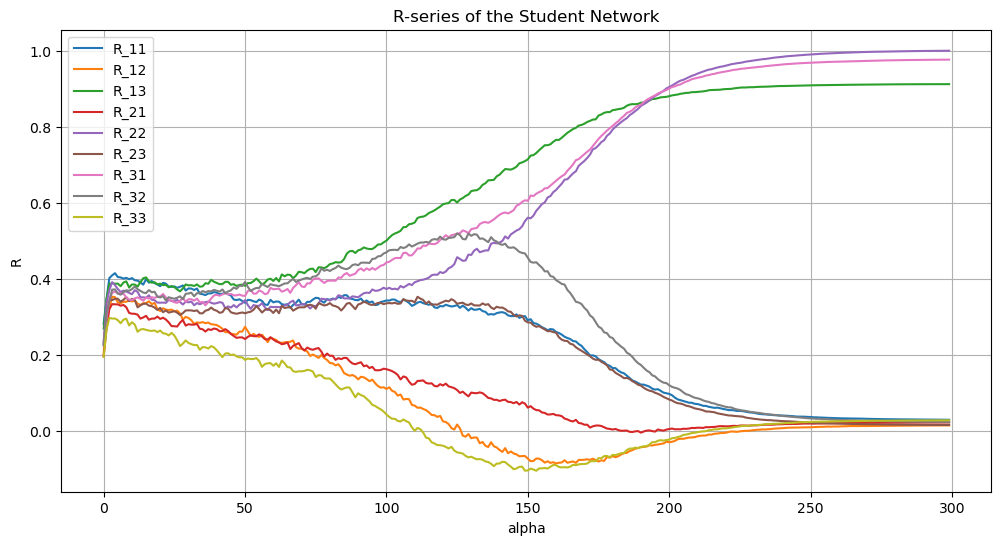

In [24]:
plt.figure(figsize=[12,6])
for i in range(num_hidden_units):
    for j in range(num_hidden_units):
        plt.plot(R_list[:, i, j], label=f"R_{i+1}{j+1}")
            
plt.xlabel('alpha')
plt.ylabel('R')
plt.legend()
plt.title('R-series of the Student Network')
plt.grid(True)
plt.show()

## Q6, Q7

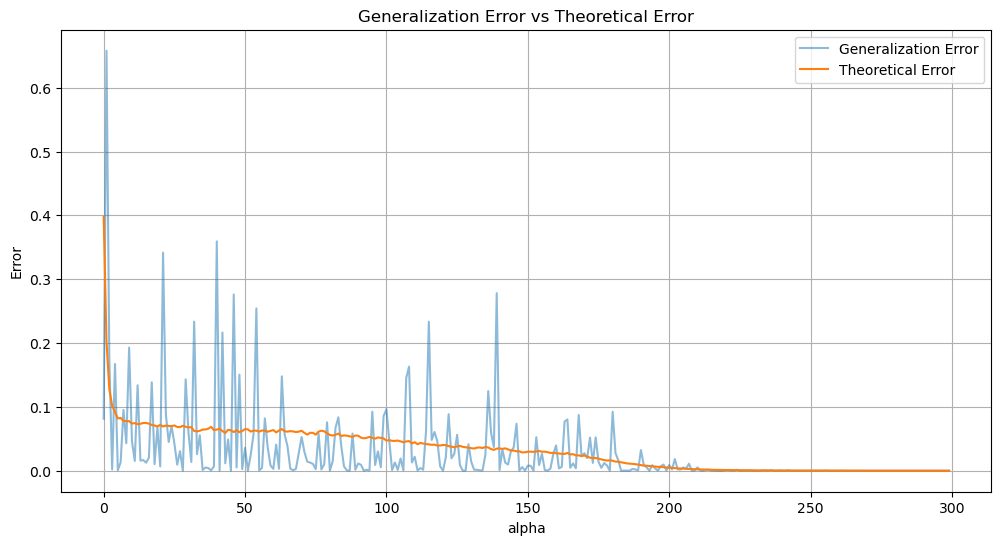

In [30]:
def compute_Q_R_T(J, B):
    R = np.dot(J, B.T) 
    Q = np.dot(J, J.T)
    T = np.dot(B, B.T) 
    return Q, R, T

def therror(Q, R, T):
    term1 = np.sum([np.arcsin(Q[i, k] / np.sqrt((1 + Q[i, i]) * (1 + Q[k, k]))) for i in range(num_hidden_units) for k in range(num_hidden_units)])
    term2 = np.sum([np.arcsin(T[n, m] / np.sqrt((1 + T[n, n]) * (1 + T[m, m]))) for n in range(num_hidden_units) for m in range(num_hidden_units)])
    term3 = -2 * np.sum([np.arcsin(R[i, n] / np.sqrt((1 + Q[i, i]) * (1 + T[n, n]))) for i in range(num_hidden_units) for n in range(num_hidden_units)])

    return (1 / np.pi) * (term1 + term2 + term3)
    
def error_comparision():
    error_list = []
    theoretical_error_list = []
    
    B = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))
    J = np.random.normal(0, np.sqrt(1/N), (num_hidden_units, N))

    for t in range(steps):
        epsion = np.random.normal(0, 1, N)
        sigma_y, g_y, y = teacher_output(B, epsion)
        sigma_x, g_x, x = student_output(J, epsion)
        delta = sigma_y - sigma_x

        for n in range(num_hidden_units):
            g_dot_x = g_dot(x[n]) 
            delta_j = rate * g_dot_x * (sigma_y - sigma_x) * epsion
            J[n] += delta_j  
        
        if (t+1) % 1000 == 0:
            errors = 0.5 * delta **2
            error_list.append(errors)
            Q, R, T =  compute_Q_R_T(J, B)
            theoretical_error_list.append(therror(Q, R, T))

    
    plt.figure(figsize=[12, 6])  
    plt.plot(error_list, label="Generalization Error",alpha=.5)
    plt.plot(theoretical_error_list, label="Theoretical Error")       
    
    plt.xlabel('alpha')
    plt.ylabel('Error')
    plt.legend()
    plt.title('Generalization Error vs Theoretical Error')
    plt.grid()
    plt.show()
    
error_comparision()